In [7]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution (ACLED Tunisia)

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Note: Tailored for ACLED Tunisia dataset (1997-2025, ~11,367 events).
# Using '../data/tunisia_acled_1997_2025.csv' (~5.7 MB).
# Filtering for ~2,623 high-risk events: Riots (1905), Violence against civilians (184),
# Battles (307), Explosions/Remote violence (227), plus sub-events like Violent demonstration.
# Improvements: Temporal features (month, day_of_week cyclic), event type weights,
# hybrid scoring (density + recency + fatalities), KDE heatmap, enhanced predictions
# (score, distance, event type), temporal weighting (alpha=0.5), noise handling (beta=10),
# dynamic eps, Tunisia map.
# DBSCAN eps=dynamic (0.01-0.1), min_samples=3-5.
# Tunisia's area (~163,610 km²) requires smaller eps vs. Chicago (~606 km²).


In [50]:

# Step 1: Load and preprocess ACLED data
acled_file = '../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv'
crime_file = '../data/tunisia_street_crime.csv'
current_year = 2025
alpha = 0.5  # Time decay parameter
beta = 10.0  # Noise distance decay parameter
event_type_weights = {
    'Battles': 2.0,
    'Violence against civilians': 3.0,
    'Explosions/Remote violence': 1.2,
    'Riots': 1.0,
    'Protests': 0.5,
    'Street Crime': 3.0
}

# Optimize data types
dtypes = {
    'latitude': 'float32',
    'longitude': 'float32',
    'event_type': 'category',
    'sub_event_type': 'category',
    'disorder_type': 'category',
    'civilian_targeting': 'category',
    'fatalities': 'int32',
    'event_date': 'object',
    'year': 'int32',
    'admin1': 'category',
    'location': 'category'
}

In [51]:


try:
    if os.path.exists(acled_file):
        print(f"Loading ACLED Tunisia Data from {acled_file}")
        df = pd.read_csv(acled_file, dtype=dtypes, usecols=[
            'latitude', 'longitude', 'event_type', 'sub_event_type', 'disorder_type',
            'civilian_targeting', 'fatalities', 'event_date', 'year', 'admin1', 'location'
        ])
        print("Columns in CSV:", df.columns.tolist())
        print("Total events:", len(df))
    else:
        print(f"No ACLED data found at {acled_file}.")
        print("Download from https://acleddata.com/data-export-tool/")
        raise FileNotFoundError("ACLED data missing")

    # Check required columns
    required_cols = ['latitude', 'longitude', 'event_type', 'sub_event_type', 'fatalities', 'year', 'event_date']
    available_cols = df.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        print(f"Error: Missing columns {missing_cols}. Available columns: {available_cols}")
        raise ValueError("Missing required columns")

    # Load street crime data if available
    if os.path.exists(crime_file):
        crime_df = pd.read_csv(crime_file, dtype={'latitude': 'float32', 'longitude': 'float32'})
        crime_df['event_type'] = 'Street Crime'
        crime_df['sub_event_type'] = 'Assault/Robbery'
        crime_df['fatalities'] = 0
        crime_df['year'] = 2025
        crime_df['event_date'] = '01/01/2025'
        crime_df['admin1'] = 'Unknown'
        df = pd.concat([df, crime_df], ignore_index=True)
        print("Added street crime data:", crime_df.shape)

except MemoryError:
    print("MemoryError: Insufficient RAM. Try closing other applications or running on Google Colab.")
    raise
except Exception as e:
    print(f"Error loading data: {e}. Ensure '../data/tunisia_acled_1997_2025.csv' exists.")
    raise


Loading ACLED Tunisia Data from ../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv
Columns in CSV: ['event_date', 'year', 'disorder_type', 'event_type', 'sub_event_type', 'civilian_targeting', 'admin1', 'location', 'latitude', 'longitude', 'fatalities']
Total events: 11367


In [52]:

# Drop rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])
print("Shape after dropping missing coordinates:", df.shape)


Shape after dropping missing coordinates: (11367, 11)


In [53]:

# Parse event_date and extract temporal features
df['event_date'] = pd.to_datetime(df['event_date'], format='%d %B %Y', errors='coerce')
df['month'] = df['event_date'].dt.month
df['day_of_week'] = df['event_date'].dt.dayofweek
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
print("Temporal features added:\n", df[['month', 'month_sin', 'month_cos', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos']].head())


Temporal features added:
    month     month_sin  month_cos  day_of_week  day_of_week_sin  \
0      6  1.224647e-16       -1.0            0         0.000000   
1      6  1.224647e-16       -1.0            0         0.000000   
2      6  1.224647e-16       -1.0            0         0.000000   
3      6  1.224647e-16       -1.0            1         0.781831   
4      6  1.224647e-16       -1.0            1         0.781831   

   day_of_week_cos  
0          1.00000  
1          1.00000  
2          1.00000  
3          0.62349  
4          0.62349  


In [54]:

# Add temporal and event type weights
df['temporal_weight'] = np.exp(-alpha * (current_year - df['year']))
df['event_type_weight'] = df['event_type'].map(event_type_weights).fillna(0.5)
df['severity_weight'] = df['temporal_weight'] * df['event_type_weight']
print("Weight distributions:\n", df[['temporal_weight', 'event_type_weight', 'severity_weight']].describe())


Weight distributions:
        temporal_weight  event_type_weight  severity_weight
count     1.136700e+04       11367.000000     1.136700e+04
mean      1.338166e-01           0.678754     7.718339e-02
std       1.966624e-01           0.426244     1.189431e-01
min       8.315287e-07           0.500000     4.157644e-07
25%       1.831564e-02           0.500000     9.157819e-03
50%       4.978707e-02           0.500000     4.104250e-02
75%       1.353353e-01           0.500000     8.208500e-02
max       1.000000e+00           3.000000     3.000000e+00


In [55]:

# Filter for high-risk events (post-2011)
high_risk_events = ['Violence against civilians', 'Riots', 'Battles', 'Explosions/Remote violence']
high_risk_sub_events = ['Violent demonstration', 'Mob violence', 'Attack', 'Remote explosive/landmine/IED', 'Excessive force against protesters']
df = df[(df['year'] >= 2011) & (
    df['event_type'].isin(high_risk_events) |
    df['sub_event_type'].isin(high_risk_sub_events) |
    df['civilian_targeting'].notna() |
    (df['fatalities'] > 0) |
    ((df['event_type'] == 'Protests') & (df['sub_event_type'] == 'Violent demonstration'))
)]
print("Shape after filtering high-risk events (year>=2011):", df.shape)
print("Event types:\n", df['event_type'].value_counts())
print("Sub-event types:\n", df['sub_event_type'].value_counts())
print("Fatalities distribution:\n", df['fatalities'].value_counts())


Shape after filtering high-risk events (year>=2011): (2620, 20)
Event types:
 event_type
Riots                         1881
Battles                        305
Explosions/Remote violence     225
Violence against civilians     174
Protests                        33
Strategic developments           2
Name: count, dtype: int64
Sub-event types:
 sub_event_type
Violent demonstration                 1640
Armed clash                            305
Mob violence                           241
Attack                                 163
Remote explosive/landmine/IED          161
Excessive force against protesters      33
Shelling/artillery/missile attack       32
Air/drone strike                        28
Abduction/forced disappearance          11
Suicide bomb                             4
Disrupted weapons use                    2
Headquarters or base established         0
Agreement                                0
Non-violent transfer of territory        0
Other                                   

In [56]:

# Check if data is sufficient
if df.shape[0] < 1000:
    print("Warning: Only", df.shape[0], "high-risk events found. Adding synthetic data for Tunis.")
    synthetic = pd.DataFrame({
        'latitude': np.random.normal(36.8065, 0.02, 300),
        'longitude': np.random.normal(10.1815, 0.02, 300),
        'event_type': 'Violence against civilians',
        'sub_event_type': 'Attack',
        'fatalities': np.random.randint(0, 2, 300),
        'event_date': pd.to_datetime('01/01/2025'),
        'year': 2025,
        'admin1': 'Tunis',
        'temporal_weight': 1.0,
        'event_type_weight': event_type_weights['Violence against civilians'],
        'severity_weight': 1.0 * event_type_weights['Violence against civilians'],
        'month': 1,
        'day_of_week': 0,
        'month_sin': np.sin(2 * np.pi * 1 / 12),
        'month_cos': np.cos(2 * np.pi * 1 / 12),
        'day_of_week_sin': np.sin(2 * np.pi * 0 / 7),
        'day_of_week_cos': np.cos(2 * np.pi * 0 / 7)
    })
    df = pd.concat([df, synthetic], ignore_index=True)
    print("Added 300 synthetic events for Tunis")
    print("New shape:", df.shape)


In [57]:

# Extract features
X = df[['latitude', 'longitude']].values
print("Coordinate ranges - Latitude: [{:.4f}, {:.4f}]".format(df['latitude'].min(), df['latitude'].max()))
print("Coordinate ranges - Longitude: [{:.4f}, {:.4f}]".format(df['longitude'].min(), df['longitude'].max()))


Coordinate ranges - Latitude: [30.2500, 37.2744]
Coordinate ranges - Longitude: [7.6557, 11.5538]


In [58]:

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (2620, 2)


Estimated eps from k-distance plot: 0.1331


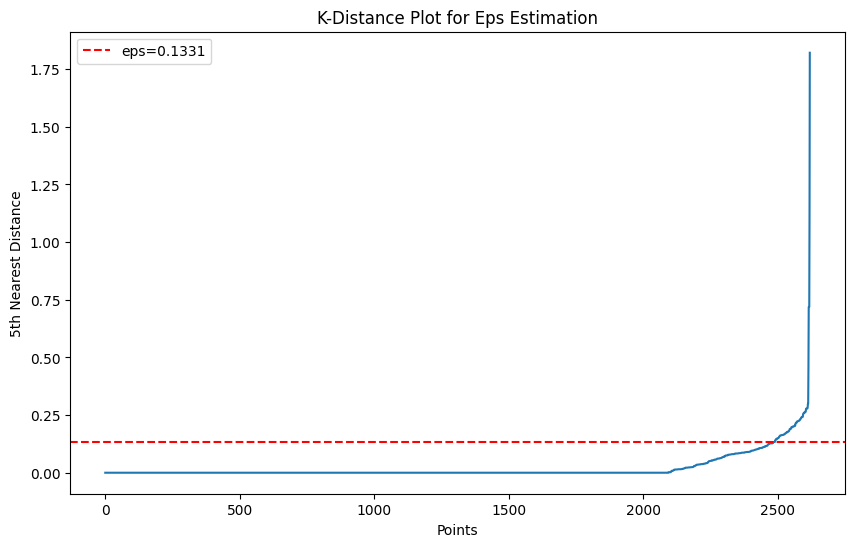

In [59]:

# Plot k-distance to estimate eps
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])
eps_estimate = np.percentile(distances, 95)
print(f"Estimated eps from k-distance plot: {eps_estimate:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('5th Nearest Distance')
plt.title('K-Distance Plot for Eps Estimation')
plt.axhline(y=eps_estimate, color='r', linestyle='--', label=f'eps={eps_estimate:.4f}')
plt.legend()
plt.show()


In [60]:

# Step 2: Apply DBSCAN clustering
#Retry with eps=0.15 or eps=0.05
eps = max(0.01, min(0.1, eps_estimate))
esp=0.05

min_samples = 5 # Minimum samples for core points #retest 3 
min_samples=3
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters

# Debug clustering
print("Cluster counts:\n", df['Cluster'].value_counts())
noise_ratio = (df['Cluster'] == -1).mean()
if noise_ratio > 0.5:
    print(f"Warning: {noise_ratio:.2%} points are noise. Increasing eps to {eps * 1.5:.4f}.")
    eps *= 1.5
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(X_scaled)
    df['Cluster'] = clusters
    print("New cluster counts:\n", df['Cluster'].value_counts())
if (df['Cluster'] == -1).all():
    print("Warning: All points are noise. Trying min_samples=3.")
    min_samples = 3
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(X_scaled)
    df['Cluster'] = clusters
    print("New cluster counts:\n", df['Cluster'].value_counts())


Cluster counts:
 Cluster
 0     418
 6     226
 7     118
-1      99
 2      78
      ... 
 89      3
 8       3
 73      3
 74      3
 75      3
Name: count, Length: 106, dtype: int64


In [61]:

# Compute dominant event type per cluster
cluster_event_types = df[df['Cluster'] != -1].groupby('Cluster')['event_type'].agg(lambda x: x.mode()[0])
print("Dominant event types per cluster:\n", cluster_event_types)


Dominant event types per cluster:
 Cluster
0        Riots
1        Riots
2        Riots
3        Riots
4        Riots
        ...   
100      Riots
101      Riots
102      Riots
103    Battles
104      Riots
Name: event_type, Length: 105, dtype: category
Categories (6, object): ['Battles', 'Explosions/Remote violence', 'Protests', 'Riots', 'Strategic developments', 'Violence against civilians']


In [62]:

# Step 3: Assign risk scores
cluster_weights = df[df['Cluster'] != -1].groupby('Cluster')['severity_weight'].sum()
cluster_fatalities = df[df['Cluster'] != -1].groupby('Cluster')['fatalities'].sum()
print("Cluster weights (non-noise):\n", cluster_weights)
print("Cluster fatalities (non-noise):\n", cluster_fatalities)
if cluster_weights.empty:
    print("Warning: No clusters formed. Setting Risk_Score to 0.0.")
    df['Risk_Score'] = 0.0
else:
    df['Risk_Score'] = df['Cluster'].map(cluster_weights).fillna(0) / cluster_weights.max()
    df['Risk_Score'] = df.apply(
        lambda x: x['Risk_Score'] * (1 + 0.1 * cluster_fatalities.get(x['Cluster'], 0)) if x['Cluster'] != -1 else 0,
        axis=1
    )
    # Ensure small clusters with severe events have minimum score
    df['Risk_Score'] = df.apply(
        lambda x: max(x['Risk_Score'], 0.1 * cluster_fatalities.get(x['Cluster'], 0) / cluster_fatalities.max()) if x['Cluster'] != -1 else x['Risk_Score'],
        axis=1
    )
    df['Risk_Score'] = df['Risk_Score'] / df['Risk_Score'].max()
print("Risk score distribution:\n", df['Risk_Score'].describe())


Cluster weights (non-noise):
 Cluster
0      33.513085
1       6.258026
2      10.976629
3       3.290630
4       1.519792
         ...    
100     0.036163
101     0.043541
102     0.037173
103     0.015784
104     0.008158
Name: severity_weight, Length: 105, dtype: float64
Cluster fatalities (non-noise):
 Cluster
0      142
1        1
2        4
3        0
4        0
      ... 
100      0
101      0
102      0
103      9
104     10
Name: fatalities, Length: 105, dtype: int32
Risk score distribution:
 count    2620.000000
mean        0.226246
std         0.372167
min         0.000000
25%         0.003316
50%         0.011236
75%         0.230926
max         1.000000
Name: Risk_Score, dtype: float64


In [63]:

# Step 4: KDE heatmap
kde = gaussian_kde([df['longitude'], df['latitude']], weights=df['severity_weight'])
x_grid, y_grid = np.meshgrid(
    np.linspace(df['longitude'].min(), df['longitude'].max(), 100),
    np.linspace(df['latitude'].min(), df['latitude'].max(), 100)
)
z = kde([x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)
z = z / z.max()  # Normalize


In [64]:

# Visualize KDE and clusters
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
tunisia = world[world['name'] == 'Tunisia']
fig, ax = plt.subplots(figsize=(10, 6))
tunisia.plot(ax=ax, color='lightgrey')
plt.contourf(x_grid, y_grid, z, levels=20, cmap='Reds', alpha=0.5)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Risk_Score', size='Risk_Score', palette='Reds', ax=ax, alpha=0.7)
plt.title('High-Risk Locations with KDE Heatmap (Tunisia ACLED Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='KDE Risk Density')
plt.show()


AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [ ]:

# Step 5: Predict risk score
def predict_risk_score(lat, lon, model, scaler, cluster_weights, cluster_fatalities, cluster_event_types, df, beta=beta):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    if len(model.components_) == 0:
        print("No core points in model. Increase eps/min_samples or add more data.")
        return (0.0, 0.0, 'None')
    distances = np.sqrt(((X_new_scaled - model.components_)**2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    max_distance = np.sqrt(((X_scaled - X_scaled.mean(axis=0))**2).sum(axis=1)).max()
    normalized_distance = distances[nearest_idx] / max_distance
    nearest_cluster = model.labels_[model.core_sample_indices_[nearest_idx]]
    event_type = cluster_event_types.get(nearest_cluster, 'Unknown')
    if distances[nearest_idx] <= model.eps:
        score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Assigned to cluster {nearest_cluster} (type: {event_type}) with score {score:.2f}, normalized distance {normalized_distance:.2f}")
    else:
        base_score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        base_score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        score = base_score * np.exp(-beta * (distances[nearest_idx] - model.eps))
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Noise point near cluster {nearest_cluster} (type: {event_type}, distance {distances[nearest_idx]:.2f} > eps {model.eps}), score {score:.2f}, normalized distance {normalized_distance:.2f}")
    return (score, normalized_distance, event_type)


In [65]:

# Example predictions
test_points = [
    (36.8065, 11.1815),  # Tunis
    (33.8815, 10.0982),  # Gabes
    (35.6754, 10.1033)   # Kairouan
]
for lat, lon in test_points:
    score, norm_dist, event_type = predict_risk_score(lat, lon, dbscan, scaler, cluster_weights, cluster_fatalities, cluster_event_types, df)
    print(f'Risk Score for ({lat}, {lon}): {score:.2f}, Norm. Distance: {norm_dist:.2f}, Nearest Cluster Type: {event_type}')


Noise point near cluster 77 (type: Riots, distance 0.10 > eps 0.1), score 0.00, normalized distance 0.02
Risk Score for (36.8065, 11.1815): 0.00, Norm. Distance: 0.02, Nearest Cluster Type: Riots
Assigned to cluster 26 (type: Riots) with score 0.00, normalized distance 0.00
Risk Score for (33.8815, 10.0982): 0.00, Norm. Distance: 0.00, Nearest Cluster Type: Riots
Assigned to cluster 2 (type: Riots) with score 0.03, normalized distance 0.00
Risk Score for (35.6754, 10.1033): 0.03, Norm. Distance: 0.00, Nearest Cluster Type: Riots


In [66]:

# Step 6: Save model
import joblib
joblib.dump(dbscan, 'risky_location_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']